# 2-D Linear Convection with Devito

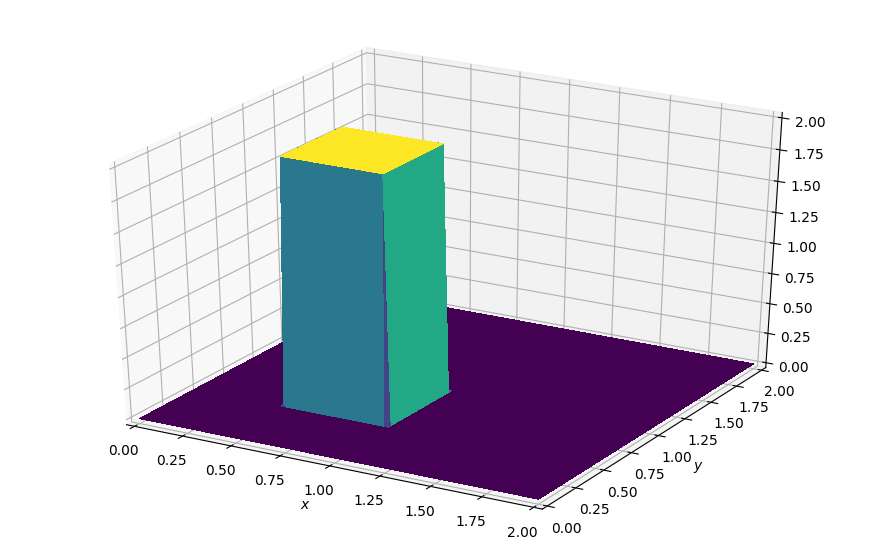

In [2]:
from devito import Grid, TimeFunction
from examples.cfd import plot_field

nt = 100 # number of timestpes
dt = 0.005
c = 1

grid = Grid(shape=(81,81), extent=(2.,2.))

u = TimeFunction(name='u', grid=grid)
for i in range(19,40):
   u.data[0][i][19:40] = 2.

plot_field(u.data[0])

In [3]:
from devito import Eq
from sympy import init_printing; init_printing(use_latex='mathjax')

eq = Eq(u.dt + c*u.dxl + c*u.dyl)
eq

u(t, x, y)   u(t, x, y - h_y)   u(t, x, y)   u(t, x - hₓ, y)   u(t, x, y)   u(
────────── - ──────────────── + ────────── - ─────────────── - ────────── + ──
   h_y             h_y              hₓ              hₓ             dt         

t + dt, x, y)    
───────────── = 0
     dt          

In [4]:
from sympy import solve

stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil[0])
update

                  dt⋅hₓ⋅(-u(t, x, y) + u(t, x, y - h_y)) + dt⋅h_y⋅(-u(t, x, y)
u(t + dt, x, y) = ────────────────────────────────────────────────────────────
                                                                 hₓ⋅h_y       

 + u(t, x - hₓ, y)) + hₓ⋅h_y⋅u(t, x, y)
───────────────────────────────────────
                                       

** Devito operator and solve **

We can now create the Devito operator that will generate the C code at runtime. When creating the operator, Devito's two optimization engines will log which performance optimizations have been performed:

- **DSE**: The Devito Symbolics Engine will attempt to reduce the number of operations required by the kernel.
- **DLE**: The Devito Loop Engine will perform various loop-level optimizations to improve runtime performance.

In [5]:
from devito import Operator, configuration
configuration["log_level"] = "DEBUG"

op = Operator(update)

DSE: extract_time_invariants [flops: 12, elapsed: 0.00] >>
     eliminate_inter_stencil_redundancies [flops: 12, elapsed: 0.00] >>
     eliminate_intra_stencil_redundancies [flops: 12, elapsed: 0.00] >>
     factorize [flops: 12, elapsed: 0.00] >>
     finalize [flops: 12, elapsed: 0.00]
     [Total elapsed: 0.01 s]
DLE: avoid_denormals [elapsed: 0.00] >>
     optimize_halo_updates [elapsed: 0.00] >>
     loop_blocking [elapsed: 0.00] >>
     simdize [elapsed: 1.05] >>
     create_elemental_functions [elapsed: 0.00] >>
     minimize_remainders [elapsed: 0.00]
     [Total elapsed: 1.06 s]


In [6]:
op(time=nt+1, dt=dt)

CustomCompiler: compiled `/tmp/devito-jitcache-uid1000/27c944dae1b3c2c7d4ee18396933e13f01a4de9f.c` [0.13 s]
Operator `Kernel` run in 0.00 s
* section0<102,81,81> with OI=1.45 computed in 0.000 s [26.95 GFlops/s, 2.25 GPts/s]


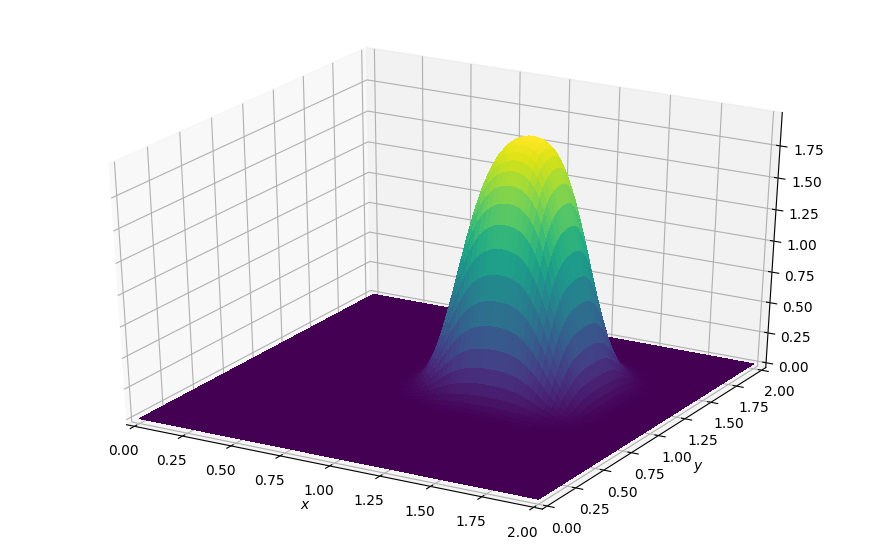

In [7]:
plot_field(u.data[0])